# PHY 3310 - Quantum Mechanics
# Bell's Inequality
-----------------------------------------------------------

Consider a thought experiment involving the singlet state

$$\left|\psi\right\rangle = \frac{1}{\sqrt{2}}\left(\left|+\right\rangle\left|-\right\rangle - \left|-\right\rangle\left|+\right\rangle\right).$$

In this thought experiment, each of the individual spins is sent to a separate observer. The observers have agreed to measure spin along one of three pre-defined axes, $\hat{\bf a}$, $\hat{\bf b}$, $\hat{\bf c}$. Each observer selects one of these axes at random for each measurement, and this process is repeated many times. At the end of the experiment, the observers can compare their measurements. Because the observers <i>might</i> use different axes for the measurement of a given singlet, it is possible that each obtains $+\frac{\hbar}{2}$ (or $-\frac{\hbar}{2}$) for their portion of the same singlet. The perfect anticorrelation appears somewhat smoothed out by this randomized axis choice.

In class, we showed that one may obtain an upper bound on the probability of both observers obtaning the same value for a given measurement by assuming some hidden variable exists which fixes the outcome of the spin measurement along any of these axes. This hidden variable partitions the (seemingly identical) individual spins into nine different "types," and we showed that this implies

$$P_{same} \leq \frac{4}{9},$$
$$P_{opp} \geq \frac{5}{9}.$$

These conditions represent a particular case of the more general <b>Bell inequality</b>, which imposes constraints on the emergent probability distribution for the results of such an experiment. This is notable, because one can also use the basic postulates of quantum mechanics to make corresponding predictions for $P_{same}$ and $P_{opp}$. For a given set of two axes $\hat{\bf n}$ and $\hat{\bf n}'$, we found

$$P_{same}(\hat{\bf n},\hat{\bf n}') = \sin^{2}\theta_{\hat{n}\hat{n}'},$$

with $P_{opp}(\hat{\bf n},\hat{\bf n}') = \cos^{2}\theta_{\hat{n}\hat{n}'}$ and $\theta_{\hat{n}\hat{n}'}$ is the angle between $\hat{\bf n}$ and $\hat{\bf n}'$. With the observers each randomly selecting their axes, we really have nine cases to consider. For simplicity, let's imagine $\hat{\bf a} = \hat{\bf z}$ while $\hat{\bf b}$ and $\hat{\bf c}$ are given by $\hat{\bf n}(\pm\theta,\phi=0)$ for some choice of $\theta$. Then averaging over the nine axis choice possibilities gives

$$P_{same} = \frac{1}{9}\left(4\sin^{2}\frac{\theta}{2}+2\sin^{2}\theta\right),$$
$$P_{opp} = \frac{1}{9}\left(3+4\cos^{2}\frac{\theta}{2}+2\cos^{2}\theta\right),$$

Note that for $\theta = \frac{2\pi}{3}$ we get

$$P_{same} = P_{opp} = \frac{1}{2}.$$

This result is in direct conflict with the Bell inequalities. Let us build a circuit that will let us actually perform this experiment using the qubits to represent the spins in a singlet. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *

from qiskit.primitives import StatevectorSampler

Let us define the angles for the three measurement axes as follows:

In [2]:
θa = 0.0
θb = 2*np.pi/3
θc = -2*np.pi/3

θ = [θa, θb, θc]

Our actual circuit will thread random choices for the first observer's axis choice and the second observer's axis choice. Additionally, we need to first create the singlet state by entangling two individual qubits. The method employed will be discussed in the next section, so we can just take on faith that this works for now. At least note that all this circuit does is to create a particular state involving several gates and then perform the appropriate rotations to measure each spin along a particular axis.

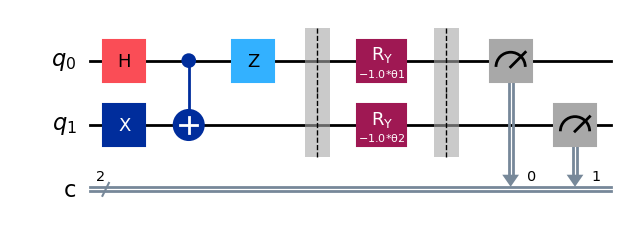

In [10]:
from qiskit.circuit import Parameter
theta1, theta2 = Parameter('θ1'), Parameter('θ2')

qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')
circ = QuantumCircuit(qr,cr)
circ.h(0)
circ.x(1)
circ.cx(0,1)
circ.z(0)
circ.barrier(qr)
circ.ry(-theta1,0)
circ.ry(-theta2,1)
circ.barrier(qr)
circ.measure(qr,cr)
circ.draw('mpl')

To simulate the thought experiment, let us consider a long list of random axis choices. There are really only 9 possible combinations, so we could technicall consider only nine cases and just use a larger number of shots per choice. But in the spirit of a true simulation, we'll make a long list of rancom choices.

For each of these $N$ choices, we randomly select a $\theta$ from the list for each observer. Just to get the best statistical gain for our buck, we'll take a large number of shots for each random configuration. 

Once we get the final counts, we simply have to look at the relative fraction of measurements for which the same result ('00' or '11') was obtained by both observers and the relative fraction for which the opposite result ('01' or '10') was obtained by the observer

In [11]:
N = 2000

theta1_vals = np.zeros(N)
theta2_vals = np.zeros(N)

for i in range(0,N):
    theta1_vals[i] = θ[np.random.randint(3)]
    theta2_vals[i] = θ[np.random.randint(3)]


# Define a sweep over parameter values, where the second axis is over.
# the two parameters in the circuit.
params = np.vstack([
    theta1_vals,
    theta2_vals
]).T

nshots = 1

sampler = StatevectorSampler()

pub = (circ, params)
job = sampler.run([pub], shots=nshots)
 
# Extract the result for the 0th pub (this example only has one pub).
result = job.result()[0]

In [12]:
Psame = 0
Popp = 0

for i in range(0,N):
    counts = result.data.c.get_counts(i)
    for j in range(0,len(list(counts.keys()))):
        if list(counts.keys())[j] == '00' or list(counts.keys())[j] == '11':
            Psame = Psame + counts[list(counts.keys())[j]]/(N*nshots)
        else:
            Popp = Popp + counts[list(counts.keys())[j]]/(N*nshots)

In [13]:
print('Psame = '+str(Psame) + ' while Bell predicts Psame < ' + str(4.0/9.0))
print('Popp = '+str(Popp) + ' while Bell predicts Popp > ' + str(5.0/9.0))

Psame = 0.5039999999999999 while Bell predicts Psame < 0.4444444444444444
Popp = 0.4960000000000004 while Bell predicts Popp > 0.5555555555555556


You should find that the simulator shows a violation of the Bell inequalities. The next step is to run this on an actual computer. Using $N = 900$ is a little risky because only certain machines support this number of circuits threaded into a single job (```ibm_lagos```, ```ibmg_jakarta```, ```ibmq_casablanca``` are the ones for which we have access). If you end up using a five qubit machine, you'll need to drop $N$ down to 75.

<b>Trying on real device</b>

In [15]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_sherbrooke'

In [86]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(circ)

In [ ]:
# Step 3: Execute using Qiskit primitives.
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
 

sampler = Sampler(backend)
job = sampler.run([(isa_circuit, params)],shots=nshots)

job_result = job.result()

In [22]:
Nsame = 0
Nopp = 0

for i in range(0,N):
    counts = job_result[0].data.c3.get_counts(i)
    for j in range(0,len(list(counts.keys()))):
        if list(counts.keys())[j] == '00' or list(counts.keys())[j] == '11':
            Nsame = Nsame + counts[list(counts.keys())[j]]
        else:
            Nopp = Nopp + counts[list(counts.keys())[j]]

Psame = Nsame/(N*nshots)
Popp = Nopp/(N*nshots)


In [26]:
print('Psame = '+str(Psame) + ' while Bell predicts Psame < ' + str(4.0/9.0))
print('Popp = '+str(Popp) + ' while Bell predicts Popp > ' + str(5.0/9.0))

Psame = 0.481 while Bell predicts Psame < 0.4444444444444444
Popp = 0.519 while Bell predicts Popp > 0.5555555555555556


<b>Exercise 1: </b> Do the quantum computer results violate Bell's theorem?

<b>Answer: </b> Yes, very much in agreement with the predictions of QM.

<b>Exercise 2: </b> Make a plot of the quantum mechanical predictions $P_{same}(\theta)$ and $P_{opp}(\theta)$. Find some choice of $\theta$ for which Bell's inequalities are <i>not</i> violated. Make a copy of the circuit used above with this choice of $\theta$, and assess whether the quantum mechanical predictions are valid.

<b>Solution: </b>

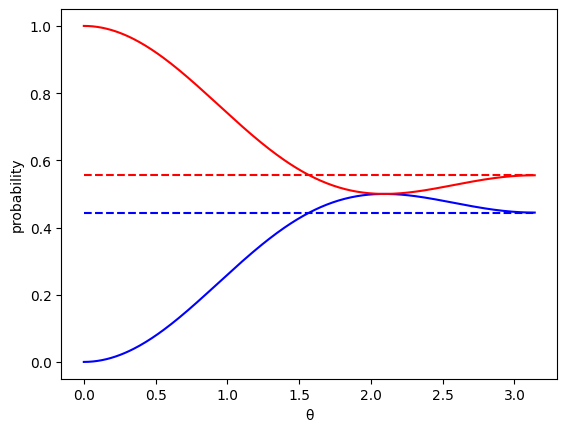

In [123]:
Ntheta = 300
theta_range = np.linspace(0,np.pi,Ntheta)

plt.plot(theta_range,(1/9)*(4*(np.sin(theta_range/2)**2) + 2*(np.sin(theta_range)**2)),'b-')
plt.plot(theta_range,(1/9)*(3+4*(np.cos(theta_range/2)**2) + 2*(np.cos(theta_range)**2)),'r-')
plt.plot(theta_range,(4/9)*np.ones(Ntheta),'b--')
plt.plot(theta_range,(5/9)*np.ones(Ntheta),'r--')
plt.xlabel('θ')
plt.ylabel('probability')
plt.show()

Fromt the plot, $\theta = \frac{\pi}{3}$ corresponds to a region in which Bell's inequality is satisfied. Specifically,

$$P_{same} = \frac{5}{18}\approx 0.278 ,\;\;\;\;\;\;\;\; P_{opp} = \frac{13}{18} \approx 0.722.$$

In this case, Bell's inequality is not violated. We can repeat the circuit using $\theta = \frac{\pi}{3}$ as follows.

In [116]:
#simulator

θa = 0.0
θb = np.pi/3
θc = -np.pi/3

θ = [θa, θb, θc]

theta1, theta2 = Parameter('θ1'), Parameter('θ2')

qr = QuantumRegister(2)
cr = ClassicalRegister(2,'c')
circ = QuantumCircuit(qr,cr)
circ.h(0)
circ.x(1)
circ.cx(0,1)
circ.z(0)
circ.barrier(qr)
circ.ry(-theta1,0)
circ.ry(-theta2,1)
circ.barrier(qr)
circ.measure(qr,cr)
circ.draw()

N = 900

nshots = 1024

theta1_vals = np.zeros(N)
theta2_vals = np.zeros(N)

for i in range(0,N):
    theta1_vals[i] = θ[np.random.randint(3)]
    theta2_vals[i] = θ[np.random.randint(3)]

params = np.vstack([
    theta1_vals,
    theta2_vals
]).T

nshots = 1

sampler = StatevectorSampler()

pub = (circ, params)
job = sampler.run([pub], shots=nshots)
 
# Extract the result for the 0th pub (this example only has one pub).
result = job.result()[0]


Psame = 0
Popp = 0

for i in range(0,N):
    counts = result.data.c.get_counts(i)
    for j in range(0,len(list(counts.keys()))):
        if list(counts.keys())[j] == '00' or list(counts.keys())[j] == '11':
            Psame = Psame + counts[list(counts.keys())[j]]/(N*nshots)
        else:
            Popp = Popp + counts[list(counts.keys())[j]]/(N*nshots)

print('Psame = '+str(Psame) + ' while Bell predicts Psame < ' + str(4.0/9.0))
print('Popp = '+str(Popp) + ' while Bell predicts Popp > ' + str(5.0/9.0))

Psame = 0.2944444444444452 while Bell predicts Psame < 0.4444444444444444
Popp = 0.7055555555555486 while Bell predicts Popp > 0.5555555555555556


Note that the actual values obtained are consistent with the predictions from QM shown above.

In [ ]:
#actual device

In [117]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_kyoto'

In [118]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(circ)

In [ ]:
sampler = Sampler(backend)
job = sampler.run([(isa_circuit, params)],shots=nshots)

result = job.result()

In [120]:
Psame = 0
Popp = 0

for i in range(0,N):
    counts = result[0].data.c.get_counts(i)
    for j in range(0,len(list(counts.keys()))):
        if list(counts.keys())[j] == '00' or list(counts.keys())[j] == '11':
            Psame = Psame + counts[list(counts.keys())[j]]/(N*nshots)
        else:
            Popp = Popp + counts[list(counts.keys())[j]]/(N*nshots)

print('Psame = '+str(Psame) + ' while Bell predicts Psame < ' + str(4.0/9.0))
print('Popp = '+str(Popp) + ' while Bell predicts Popp > ' + str(5.0/9.0))

Psame = 0.28000000000000064 while Bell predicts Psame < 0.4444444444444444
Popp = 0.7199999999999924 while Bell predicts Popp > 0.5555555555555556


## Version information:

In [121]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.25.0'

In [122]:
import qiskit 

qiskit.version.get_version_info()

'1.1.1'